In [42]:
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import signal
import matplotlib.pyplot

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

def get_periodgram(sc_data):
    return [signal.periodogram(sc_data.X[i:]) for i in range(sc_data.shape[0])]

def plot_one_row_line(df, row_num):
    df.iloc[row_num,:].plot.line()
    
def plot_one_row_scatter(df, row_num, time):
    matplotlib.pyplot.scatter(df.iloc[row_num,:], time)
      

def get_periodgram1(sc_data):
    return [signal.periodogram(sc_data.X[:i]) for i in range(sc_data.shape[0])]



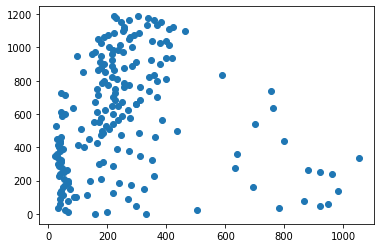

In [43]:
s745_df = get_normed_and_zero_filtered_data("data/sub_0745_miRNA.ec.tab")
s745_time = get_s745_time(s745_df.columns)
s814_df = get_normed_and_zero_filtered_data("data/sub_0814_miRNA.ec.tab")

plot_one_row_scatter(s745_df, 1,s745_time )


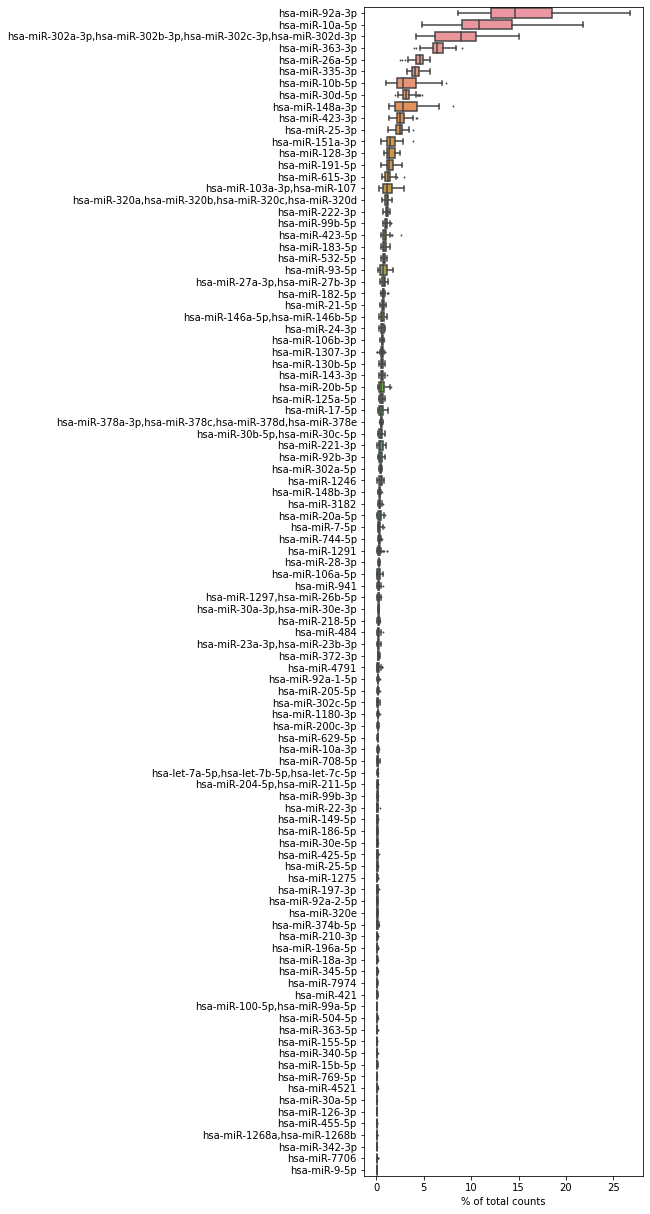

In [44]:
 
s814_adata = sc.read("data/sub_0814_miRNA.ec.tab").T

s814_adata.obs['time'] = get_s814_time(s814_adata.obs.index)

sc.pp.normalize_total(s814_adata)
sc.pp.filter_genes(s814_adata, min_counts=1)
sc.pl.highest_expr_genes(s814_adata, n_top=100, )
s814_pd = get_periodgram(s814_adata)


In [33]:
obj.apply(mean)
mean(obj)

s814_pd = s814_df.apply(signal.periodogram, axis=1)

NameError: name 'obj' is not defined

In [34]:
s814_pd.shape
np.log(s814_pd[1][1]+1)



AttributeError: 'list' object has no attribute 'shape'

ValueError: x and y must be the same size

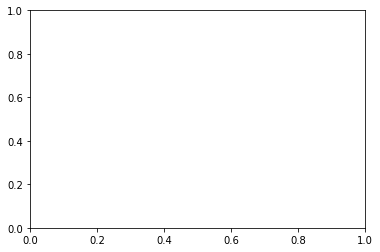

In [35]:
for i in range(10):
    matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

ValueError: x and y must be the same size

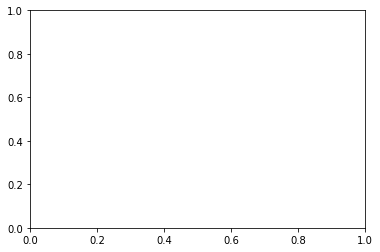

In [36]:
for i in range(10,20):
    matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

ValueError: x and y must be the same size

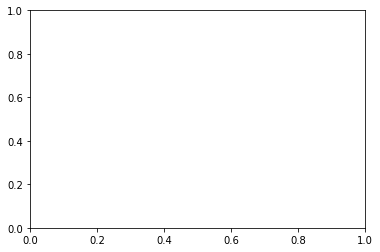

In [37]:
for i in range(20,30):
    matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

In [49]:
s814_pd = get_periodgram1(s814_adata)
s814_pd = s814_pd[:30]
s814_pd = [el[1][:15] for el in s814_pd]

print(s814_pd[0].shape)

print(s814_adata[0].shape)




(0, 1671)
(1, 1671)
